<a href="https://colab.research.google.com/github/douglaseaf15/Classif_Gene_mus_with_pytorch/blob/master/Classificacao_Generos_musicais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

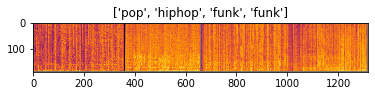

In [20]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
"""#Faz o download e descompacta o dataset de treino e teste
!rm hymenoptera_data.zip
!rm -r hymenoptera_data

# Downloading data.
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip -O hymenoptera_data.zip

# Decompressing data.
!unzip -q hymenoptera_data.zip

!ls"""

'#Faz o download e descompacta o dataset de treino e teste\n!rm hymenoptera_data.zip\n!rm -r hymenoptera_data\n\n# Downloading data.\n!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip -O hymenoptera_data.zip\n\n# Decompressing data.\n!unzip -q hymenoptera_data.zip\n\n!ls'

In [0]:
visualize_model(model_ft)

NameError: ignored

### Visualize a few images

Let's visualize a few training images so as to understand the data
augmentations.



In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
rm -rf ./sample_data

# Começa aqui!


#Aqui é montado a minha pasta do Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Aqui é baixado a pasta com as imagens das músicas que forma treansformadas em espectogramas

In [0]:
import zipfile
cam = str("/content/drive")
cam = cam +'/'+"My Drive/"+"estilos_.zip"
with zipfile.ZipFile(cam, 'r') as zip_ref:
    zip_ref.extractall("./")

#Adicionando as bibliotecas necessárias para o problema de classificação

In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline

plt.ion()   # interactive mode

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
       # transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
        'test': transforms.Compose([
       # transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/estilos_'

#image_datasets é um dicionário em que  as chaves são train e val e os valores são as pastas com as imagens tranformadas
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

#dataloaders é um dicionário que alimenta o modelo com as chaves train e val 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

#O dicionário dataset_sizes recebe duas tuplas com os nomes dos dados de treinamento e validação e seus respectivos tamanhos
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

#A variável class_names recebe o nome das classes do dicionário image_datasets
class_names = image_datasets['train'].classes

#O dispositivo padrão a ser utilizado será a GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [0]:
#model_ft = models.vgg16(pretrained=True)
#print(model_ft)

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 11 )

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized , momentum=0.9
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Visualizing the model predictions

Generic function to display predictions for a few images




In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.9099 Acc: 0.3375
val Loss: 1.7238 Acc: 0.4818

Epoch 1/24
----------
train Loss: 1.4696 Acc: 0.4966
val Loss: 1.6248 Acc: 0.5182

Epoch 2/24
----------
train Loss: 1.2290 Acc: 0.5932
val Loss: 1.3054 Acc: 0.6182

Epoch 3/24
----------
train Loss: 0.9856 Acc: 0.6761
val Loss: 1.1312 Acc: 0.6364

Epoch 4/24
----------
train Loss: 0.7813 Acc: 0.7364
val Loss: 1.4583 Acc: 0.5727

Epoch 5/24
----------
train Loss: 0.6071 Acc: 0.8170
val Loss: 1.2370 Acc: 0.6636

Epoch 6/24
----------
train Loss: 0.3468 Acc: 0.8898
val Loss: 0.8567 Acc: 0.7545

Epoch 7/24
----------
train Loss: 0.2334 Acc: 0.9432
val Loss: 0.8175 Acc: 0.7545

Epoch 8/24
----------
train Loss: 0.1992 Acc: 0.9489
val Loss: 0.8639 Acc: 0.7273

Epoch 9/24
----------
train Loss: 0.1897 Acc: 0.9511
val Loss: 0.7957 Acc: 0.7909

Epoch 10/24
----------
train Loss: 0.1897 Acc: 0.9568
val Loss: 0.8446 Acc: 0.7636

Epoch 11/24
----------
train Loss: 0.1447 Acc: 0.9727
val Loss: 0.8104 Acc: 0.7545

Epoch 12/24
----------
t

# Depois de treinar o modelo, agora, usaremos um conjunto de imagens de teste 

In [0]:
torch.save(model_ft.state_dict(), "./drive/My Drive/modelo")

In [0]:
class_names

['blues',
 'classical',
 'country',
 'disco',
 'funk',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [0]:
nb_classes = 11

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[ 6.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.],
        [ 0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  8.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  1.,  6.,  0.,  1.,  0.,  0.,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  8.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  9.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  7.,  1.,  0.],
        [ 0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  7.,  0.],
        [ 0.,  1.,  0.,  1.,  0.,  2.,  1.,  1.,  0.,  1.,  3.]])


In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
tensor([[ 6.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.],
        [ 0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  8.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  1.,  6.,  0.,  1.,  0.,  0.,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  8.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  9.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  7.,  1.,  0.],
        [ 0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  7.,  0.],
        [ 0.,  1.,  0.,  1.,  0.,  2.,  1.,  1.,  0.,  1.,  3.]])


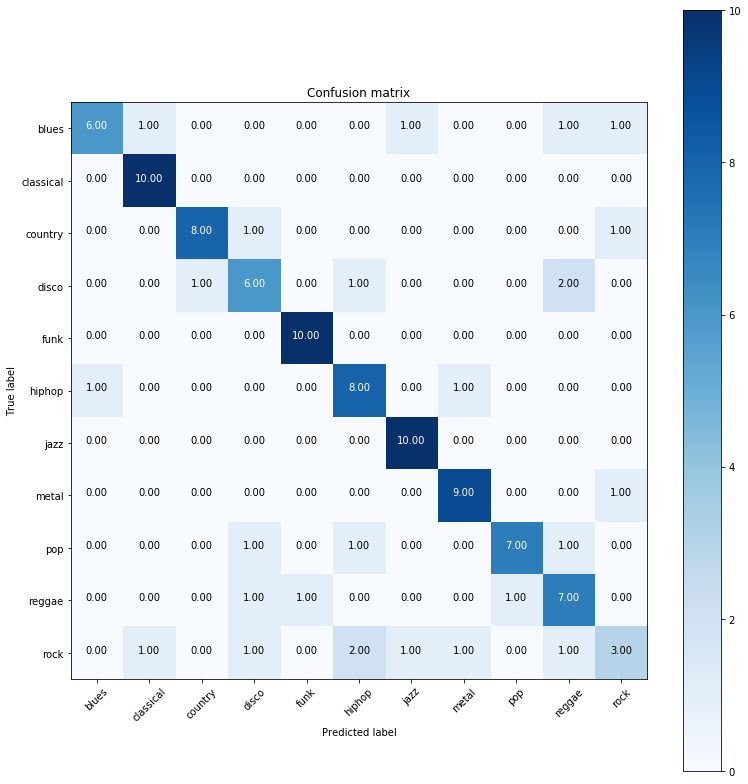

In [0]:
plt.figure(figsize=(11,11))
plot_confusion_matrix(confusion_matrix, class_names)

In [0]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([0.6000, 1.0000, 0.8000, 0.6000, 1.0000, 0.8000, 1.0000, 0.9000, 0.7000,
        0.7000, 0.3000])
